<a href="https://colab.research.google.com/github/Abdulhamid97Mousa/Hand_Signs_Data/blob/main/Hands_Signs_Image_Classification_Transfer_Learning_Resnet18_4_4_2022_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction to Transfer Learning**
When we take a model created and trained elsewhere on a similar problem that we are trying to solve, and reuse its architecture and (possibly) its weights in our setting, we are applying Transfer Learning. It means that somebody trained a Neural Network model, on most likely a very large dataset, and put that pre-trained model in a model repository. We take that model and modify it a little bit to adapt it to our use case, thus transferring the learning achieved by that model previously to our application, without having to retrain it from scratch. This not only saves time but also transfers the ”knowledge” of the model to our case, which usually results in achieving very high accuracy.

Essentially, we are building on other people’s work who make it available for the greater good. It’s a great step towards democratization of deep learning and Artificial Intelligence in general. Transfer learning is a highly effective technique used throughout the world by Deep Learning practitioners today.

Transfer Learning is most effective when the use case is well-understood and the data is sort of ”fixed” so to speak, for example, image classification and object detection which are based on just pixels, or Natural Language Processing (NLP) text corpuses which are words out of a large vocabulary.

It may not be that effective for structured or tabular data used in business settings e.g. data collected from databases and files because one company’s data may be quite different in structure and semantics from others. However, even that is changing now with recent trend in the use of categorical embeddings just like word embeddings used in NLP. Such embeddings allow us to transfer the learning achieved through data of one organization for a specific domain (e.g. predicting retail sales) to similar problems of others in the same domain.

# Hand Signs Classification

A Hand Signs Classifier using fine-tuned ResNet18 Neural Network architecture with almost 70 % Accuracy achieved by applying the method of Transfer Learning.

Given a Hand signs images, classify the images into `0, 1, 2, 3, 4, 5, 6, 7, 8, 9`

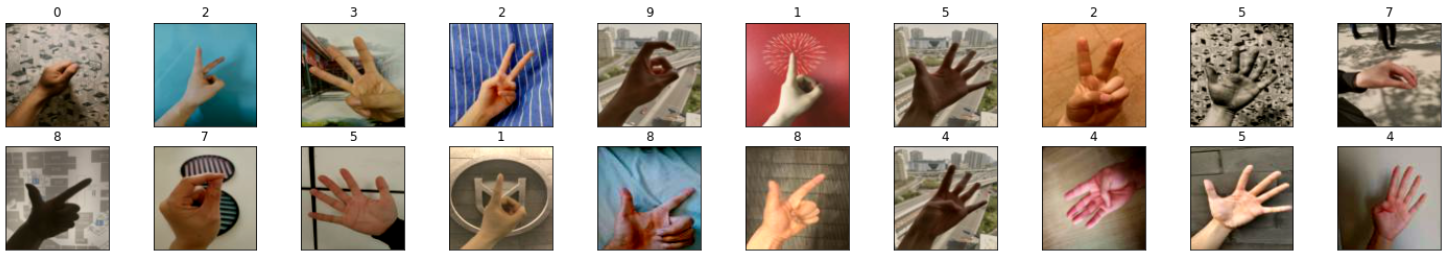


## **1. Import Necessary Libraries**
We'll be using the following libraries to complete our classification problem:

*  Numpy - For linear algebra operations
*  Torch - Pytorch Deep Learning Framework
*  Torch NN - Neural network class from Pytorch library
*  Torch NN Functional - Functional Neural Network class from Pytorch library
*  Torch Utils Data: DataLoader, Dataset - Dataset class used to create custom dataset class by subclassing it and DataLoader is used to laod data in batches using dataset class in real-time.
*  Torchvision: Transforms, Models - Trochvision provides augmentation techniques using transforms class and transfer learning models are available in models class
*  OS - To use Operating System methods
*  Random - To set random seed at specific places where random operations take place just so it happens the same way everytime it is executed
*  Pandas - To create DataFrame, CSV files, etc
*  Time - To perform date time operations


*  Scikit-Learn - For evaluating our Classifier and for cross-validation split
*  atplotlib - To visualize images, losses and accuracy
*  Google Colab Drive - To mount Google Drive so we can perform storage and loading operations using it

In [ ]:
import errno, os
import requests
import scipy.io as sio
import numpy as np

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile 
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
from torchvision import transforms, datasets, models
from torch import optim, cuda
from torch.utils.data import  sampler

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Others
from IPython.core.debugger import set_trace
from pathlib import Path

In [ ]:
torch.__version__

'1.10.0+cu111'

In [ ]:
!nvidia-smi

Tue Apr  5 06:07:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import Google Drive for persistent storage of our training data, neural network model weights and other required files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Empty GPU's memory/cache for training so we'd clear garbage values in it and more memory will be available

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(os.getcwd())
filename = os.path.join(os.getcwd(), 'repo.zip')
print(filename)

/content
/content/repo.zip


In [ ]:
filename = os.path.join(os.getcwd(), 'repo.zip')
url = 'https://github.com/Abdulhamid97Mousa/Hand_Signs_Data/archive/refs/heads/main.zip'


r = requests.get(url)
print(filename)
with open(filename, 'wb') as f:
    f.write(r.content)


file_name = "/content/repo.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Finished Extracting!') 

/content/repo.zip
Extracting all the files now...
Finished Extracting!


In [ ]:
def create_dir(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)
    print("Created Directory : ", dir)
  else:
    print("Directory already existed : ", dir)
  return dir

In [ ]:
data = create_dir("/content/Data")

Created Directory :  /content/Data


In [ ]:
file_name = "/content/Hand_Signs_Data-main/gesture_images.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
  
    # extracting all the files 
    print('Extracting all the files now...')
    zip.extractall(data) 
    print('Finished Extracting!') 

Extracting all the files now...
Finished Extracting!


In [ ]:
from matplotlib import image
from matplotlib import pyplot
import matplotlib.pyplot as plt
from PIL import Image

##**2. Image Preprocessing**
To prepare the images for our network, we have to extract them and normalize each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image transforms, which prepare our data for a neural network.

## **Python Pillow - Using Image Module**
###Opening, rotating and displaying an image
To load the image, we simply import the image module from the pillow and call the Image.open(), passing the image filename.

Instead of calling the Pillow module, we will call the PIL module as to make it backward compatible with an older module called Python Imaging Library (PIL). That’s why our code starts with `“from PIL import Image”` instead of “from Pillow import Image”.

Next, we’re going to load the image by calling the `Image.open()` function, which returns a value of the Image object data type. Any modification we make to the image object can be saved to an image file with the save() method. The image object we received using Image.open(), later can be used to resize, crop, draw or other image manipulation method calls on this Image object.

## Extract images from `Data folder: '/content/Data' ` using Image.open()
*  define a function that will help us extract images from a specific directory

In [ ]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

* `A_0` : Hand sign of zero
* `A_1` : Hand sign of one
* `A_2` : Hand sign of two
* `A_3` : Hand sign of three
* `A_4` : Hand sign of fuar
* `A_5` : Hand sign of five
* `A_6` : Hand sign of six
* `A_7` : Hand sign of seven
* `A_8` : Hand sign of eight
* `A_9` : Hand sign of nine

In [ ]:
# ------------------ getting image files -------------------- #
A_0 = load_images('/content/Data/A0')
A_1 = load_images('/content/Data/A1')
A_2 = load_images('/content/Data/A2')
A_3 = load_images('/content/Data/A3')
A_4 = load_images('/content/Data/A4')
A_5 = load_images('/content/Data/A5')
A_6 = load_images('/content/Data/A6')
A_7 = load_images('/content/Data/A7')
A_8 = load_images('/content/Data/A8')
A_9 = load_images('/content/Data/A9')

*  The amount of photos in each folder from `A_0 to A_9`

In [ ]:
# --------------------- knowing the number of images in each file ----------- #
print(len(A_0))
print(len(A_1))
print(len(A_2))
print(len(A_3))
print(len(A_4))
print(len(A_5))
print(len(A_6))
print(len(A_7))
print(len(A_8))
print(len(A_9))

159
160
160
160
160
160
160
160
160
160


## **Attributes of Image Module**
1. Image.filename
2. Image.format
3. Image.mode
4. Image.size
5. Image.info

In [ ]:
print(A_0[0].filename)
print(A_0[0].format)
print(A_0[0].mode)
print(A_0[0].size)
print(A_0[0].info)

/content/Data/A0/00230.jpg
JPEG
RGB
(100, 100)
{'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}


## **Images are comprised of matrices of pixel values.**

Black and white images are single matrix of pixels, whereas color images have a separate array of pixel values for each color channel, such as red, green, and blue.

Pixel values are often unsigned integers in the range between **`0 and 255`**. Although these pixel values can be presented directly to neural network models in their raw format, this can result in challenges during modeling, such as in the slower than expected training of the model.

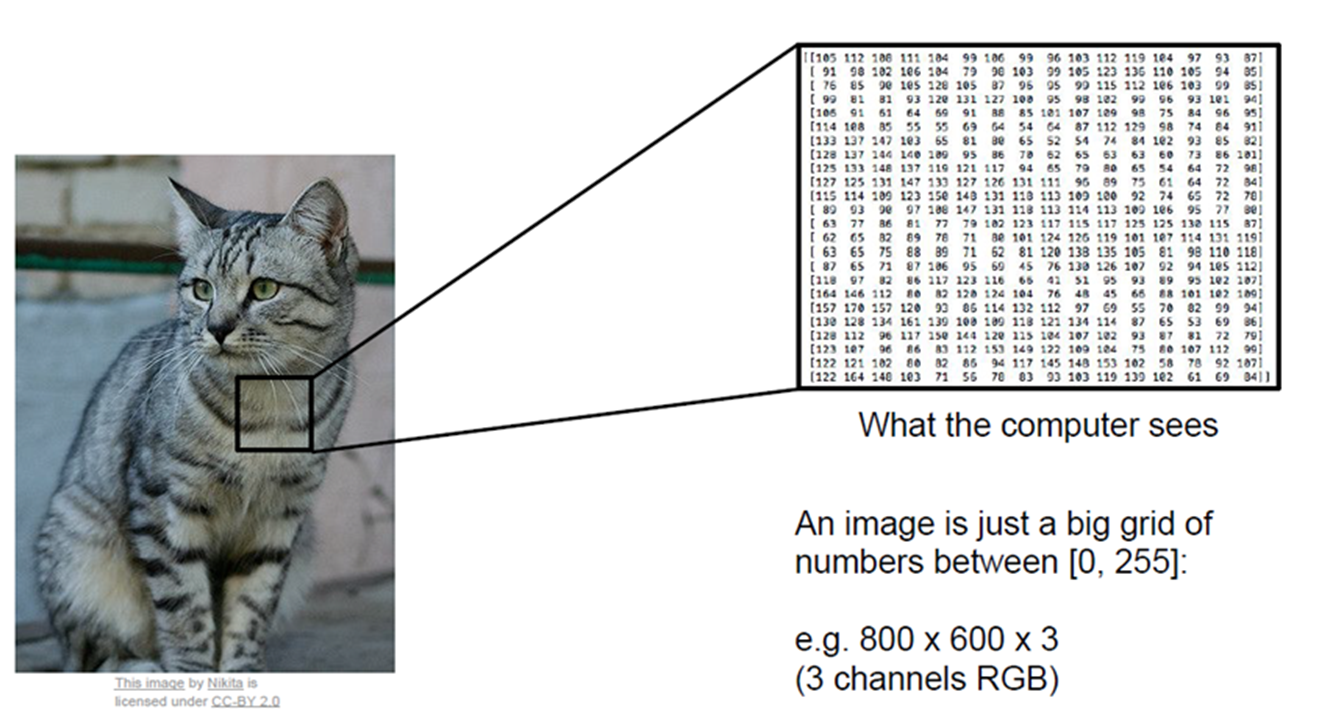

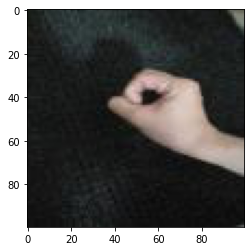

In [ ]:
single_image = np.array(A_0[0])
plt.imshow(single_image)

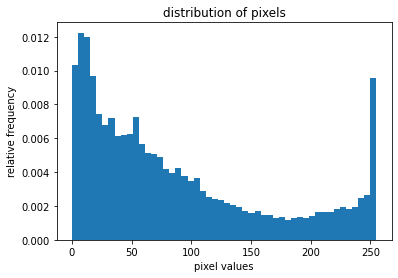

In [ ]:
single_image = np.array(A_0[4])
plt.hist(np.array(single_image).ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")
plt.show()

## **Why should we normalize images?**
Normalization helps get data within a range and reduces the skewness which helps learn faster and better. Normalization can also tackle the diminishing and exploding gradients problems.

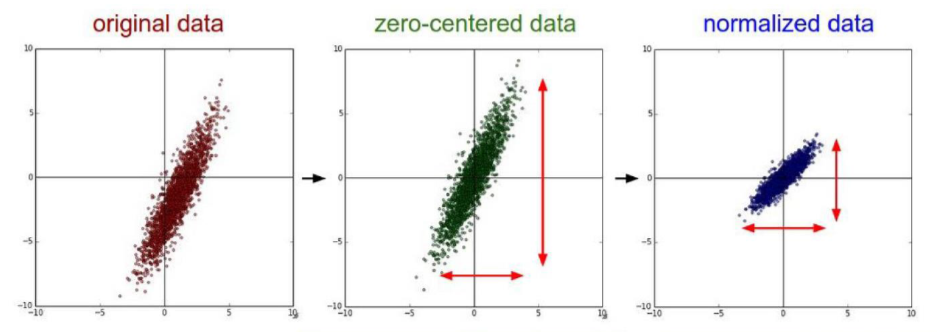

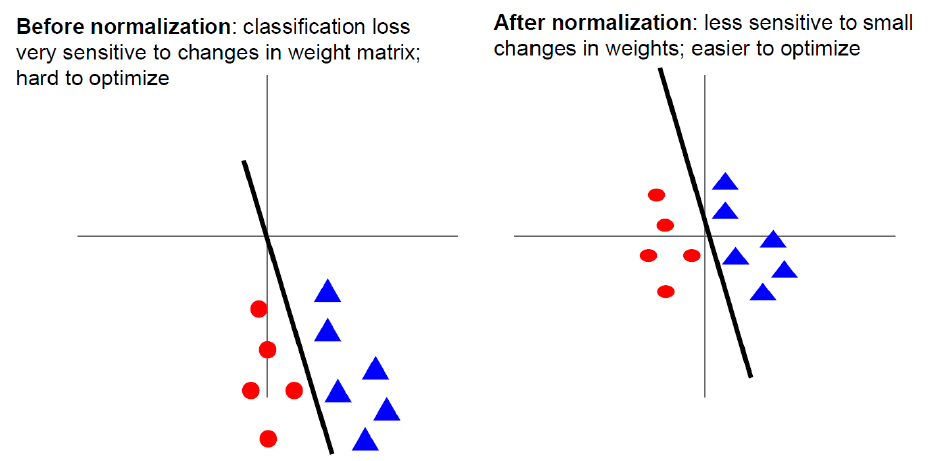

## **How to normalize images in PyTorch ?**
1. Normalization in PyTorch is done using torchvision.transforms.Normalize(). This normalizes the tensor image with mean and standard deviation. 
2. We can define a function manually:


*   How to normalize pixel values to a range between zero and one.
*   How to center pixel values both globally across channels and locally per channel.
*   How to standardize pixel values and how to shift standardized pixel values to the positive domain.

## **Normalize Pixel Values**
For most image data, the pixel values are integers with values between `0 and 255`.

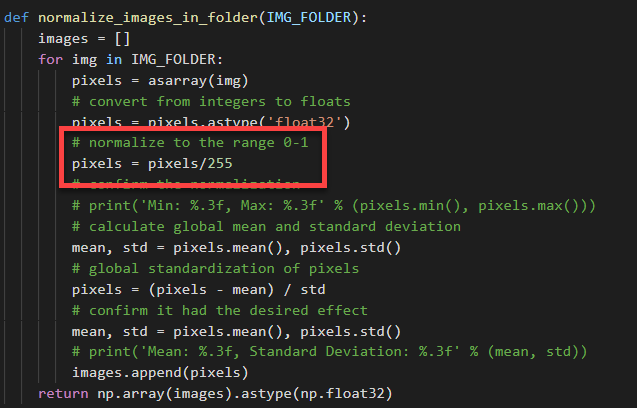

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.

It is valid for images to have pixel values in the range 0-1 and images can be viewed normally.

This can be achieved by dividing all pixels values by the largest pixel value; that is 255. This is performed across all channels, regardless of the actual range of pixel values that are present in the image.

## **Standardize Pixel Values**


> The distribution of pixel values often follows a Normal or Gaussian distribution, e.g. bell shape.



> This distribution may be present per image, per mini-batch of images, or across the training dataset and globally or per channel.



> As such, there may be benefit in transforming the distribution of pixel values to be a standard Gaussian: that is both centering the pixel values on zero and normalizing the values by the standard deviation. The result is a standard Gaussian of pixel values with a mean of 0.0 and a standard deviation of 1.0.




> As with centering, the operation can be performed per image, per mini-batch, and across the entire training dataset, and it can be performed globally across channels or locally per channel.



> Standardization may be preferred to normalization and centering alone and it results in both zero-centered values of small input values, roughly in the range`-3 to 3`, depending on the specifics of the dataset.





> For consistency of the input data, it may make more sense to standardize images per-channel using statistics calculated per mini-batch or across the training dataset, if possible.







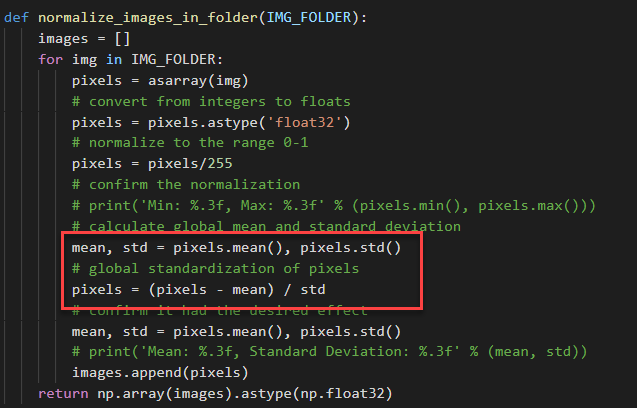

## **Global Standardization**
The example below calculates the mean and standard deviation across all color channels in the loaded image, then uses these values to standardize the pixel values.

In [ ]:
# example of pixel normalization
from numpy import asarray

In [ ]:
def normalize_images_in_folder(IMG_FOLDER):
    images = []
    for img in IMG_FOLDER:
        pixels = asarray(img)
        # convert from integers to floats
        pixels = pixels.astype('float32')
        # normalize to the range 0-1
        pixels = pixels/255
        # confirm the normalization
        # print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
        # calculate global mean and standard deviation
        mean, std = pixels.mean(), pixels.std()
        # global standardization of pixels
        pixels = (pixels - mean) / std
        # confirm it had the desired effect
        # mean, std = pixels.mean(), pixels.std()
        # print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
        images.append(pixels)
    return np.array(images).astype(np.float32)

In [ ]:
def give_image_a_label(images, label):
    storage = []
    for i in range(images.shape[0]):
        storage.append(label)

    return np.array(storage).astype(np.float32)

* Let's apply normalization and standardization and let's inspect the effect of our normalization function

In [ ]:
A_0 = normalize_images_in_folder(A_0)
print(A_0.shape)
y_0 = give_image_a_label(A_0, 0)
print(A_0[0].shape)
print(y_0[0])

(159, 100, 100, 3)
(100, 100, 3)
0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


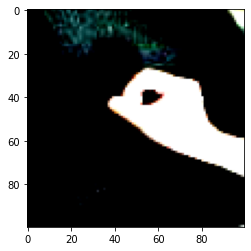

In [ ]:
single_image = A_0[0]
plt.imshow(single_image)

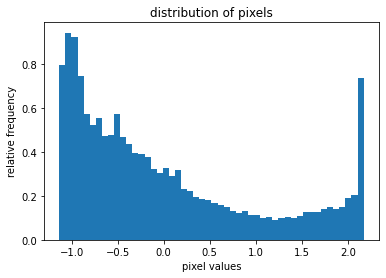

In [ ]:
plt.hist(A_0[4].ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")
plt.show()

## Keeping data and label seperate

* `A_0` is a variable that contains all `0s` hand signs data from our small dataset, we also asigned a label `0` to each image in A_0
* `A_1` is a variable that contains all `1s` hand signs data from our small dataset, we also asigned a label `1` to each image in A_1
* `A_2` is a variable that contains all `2s` hand signs data from our small dataset, we also asigned a label `2` to each image in A_2
* `A_3` is a variable that contains all `3s` hand signs data from our small dataset, we also asigned a label `3` to each image in A_3
* `A_4` is a variable that contains all `4s` hand signs data from our small dataset, we also asigned a label `4` to each image in A_4
* `A_5` is a variable that contains all `5s` hand signs data from our small dataset, we also asigned a label `5` to each image in A_5
* `A_6` is a variable that contains all `6s` hand signs data from our small dataset, we also asigned a label `6` to each image in A_6
* `A_7` is a variable that contains all `7s` hand signs data from our small dataset, we also asigned a label `7` to each image in A_7
* `A_8` is a variable that contains all `8s` hand signs data from our small dataset, we also asigned a label `8` to each image in A_8
* `A_9` is a variable that contains all `9s` hand signs data from our small dataset, we also asigned a label `9` to each image in A_9


In [ ]:
A_1 = normalize_images_in_folder(A_1)
y_1 = give_image_a_label(A_1,1)
print(A_1[0].shape)
print(y_1[0])

A_2 = normalize_images_in_folder(A_2)
y_2 = give_image_a_label(A_2, 2)
print(A_2[0].shape)
print(y_2[0])

A_3 = normalize_images_in_folder(A_3)
y_3 = give_image_a_label(A_3, 3)
print(A_3[0].shape)
print(y_3[0])

A_4 = normalize_images_in_folder(A_4)
y_4 = give_image_a_label(A_4,4)
print(A_4[0].shape)
print(y_4[0])

A_5 = normalize_images_in_folder(A_5)
y_5 = give_image_a_label(A_5,5)
print(A_5[0].shape)
print(y_5[0])

A_6 = normalize_images_in_folder(A_6)
y_6 = give_image_a_label(A_6, 6)
print(A_6[0].shape)
print(y_6[0])

A_7 = normalize_images_in_folder(A_7)
y_7 = give_image_a_label(A_7, 7)
print(A_7[0].shape)
print(y_7[0])


A_8 = normalize_images_in_folder(A_8)
y_8 = give_image_a_label(A_8, 8)
print(A_8[0].shape)
print(y_8[0])


A_9 = normalize_images_in_folder(A_9)
y_9 = give_image_a_label(A_9, 9)
print(A_9[0].shape)
print(y_9[0])

(100, 100, 3)
1.0
(100, 100, 3)
2.0
(100, 100, 3)
3.0
(100, 100, 3)
4.0
(100, 100, 3)
5.0
(100, 100, 3)
6.0
(100, 100, 3)
7.0
(100, 100, 3)
8.0
(100, 100, 3)
9.0


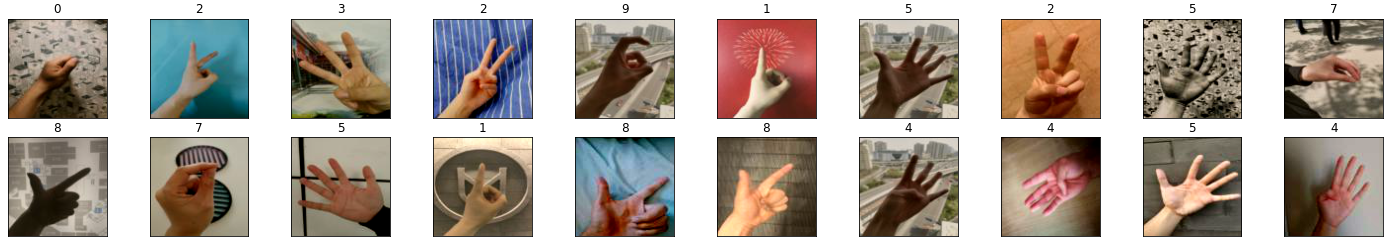

## From Numpy Matrix to Torch Tensor
*  objective: Here we're just converting from numpy array to torch tensor

*  `torch.from_numpy(numpy array list)  H x W x C`
*  the output is a normalized and standardized tensor with shape H x W x C

In [ ]:
# convert numpy array to torch tensor
A_0 = torch.from_numpy(A_0)
A_1 = torch.from_numpy(A_1)
A_2 = torch.from_numpy(A_2)
A_3 = torch.from_numpy(A_3)
A_4 = torch.from_numpy(A_4)
A_5 = torch.from_numpy(A_5)
A_6 = torch.from_numpy(A_6)
A_7 = torch.from_numpy(A_7)
A_8 = torch.from_numpy(A_8)
A_9 = torch.from_numpy(A_9)

y_0 = torch.from_numpy(y_0)
y_1 = torch.from_numpy(y_1)
y_2 = torch.from_numpy(y_2)
y_3 = torch.from_numpy(y_3)
y_4 = torch.from_numpy(y_4)
y_5 = torch.from_numpy(y_5)
y_6 = torch.from_numpy(y_6)
y_7 = torch.from_numpy(y_7)
y_8 = torch.from_numpy(y_8)
y_9 = torch.from_numpy(y_9)

## Concatenation of images
*  We're trying to keep each variable seperate and change the matrix type from numpy matrix to torch tensor
 
*  `torch.from_numpy(numpy array list)  H x W x C`

In [ ]:
# concatenate the data of normal, ball, inner_race, outer_race
X = torch.cat((A_0, A_1, A_2, A_3, A_4, A_5, A_6, A_7, A_8, A_9), dim=0)
print(X.shape)

torch.Size([1599, 100, 100, 3])


In [ ]:
# concatenate the label data of normal, ball, inner_race, outer_race
y = torch.cat((y_0, y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9), dim=0)
print(y.shape)

torch.Size([1599])


In [ ]:
train = X
test = y
print(train.shape)
print(test.shape)

torch.Size([1599, 100, 100, 3])
torch.Size([1599])




> In the model-building phase of any supervised machine learning project, we train a model with the aim to learn the optimal values for all the weights and biases from labeled examples. If we use the same labeled examples for testing our model then it would be a methodological mistake because a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting.



> To overcome the problem of overfitting we use cross-validation. So you must what is cross-validation ? and how can it solve the problem of overfitting?



## **What is Cross-validation?**


> Cross-validation is a statistical method used to estimate the performance of machine learning models. It is a method for assessing how the results of a statistical analysis will generalize to an independent data set.


## **How does it tackle the problem of overfitting?**


> In Cross-Validation, we use our initial training data to generate multiple mini train-test splits. Use these splits to tune your model. For example in standard k-fold cross-validation, we partition the data into k subsets. Then, we iteratively train the algorithm on k-1 subsets while using the remaining subset as the test set. In this way, we can test our model on completely unseen data. In this article, you can read about the 3 most commonly used cross-validation techniques along with their pros and cons. I have also provided the code snippets for each technique.




The techniques are listed below:

1. Hold Out Cross-validation

2. K-Fold cross-validation

3. Stratified K-Fold cross-validation

## **1.HoldOut Cross-validation or Train-Test Split**
>In this technique of cross-validation, the whole dataset is randomly partitioned into a training set and validation set. Using a rule of thumb nearly 70% of the whole dataset is used as a training set and the remaining 30% is used as the validation set.





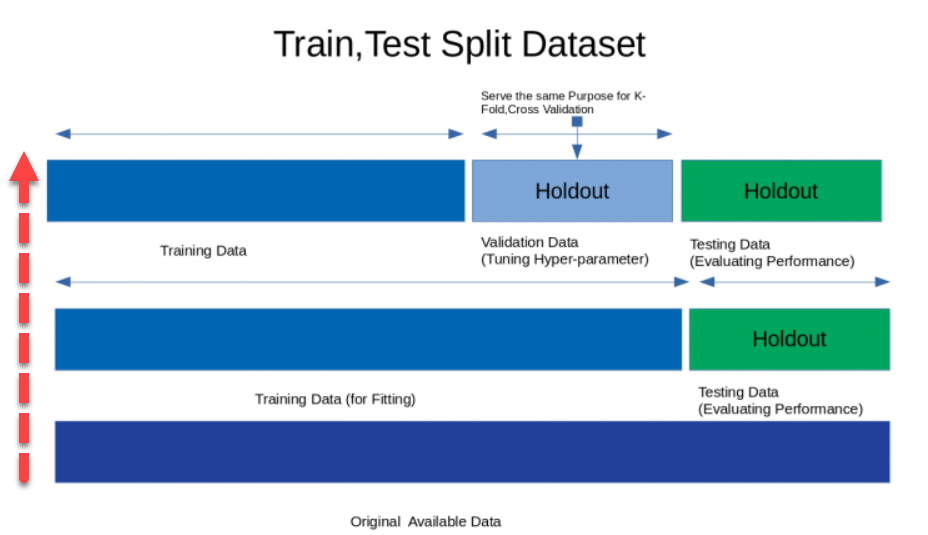

In [ ]:
# set aside 20% of train and test data for evaluation
X_train, X_val, y_train, y_val = train_test_split(train, test,
    test_size=0.3, random_state = 8)
print("X_train shape: {}, dtype: {}".format(X_train.shape, type(X_train)))
print("y_train shape: {}".format(y_train.shape))

X_train shape: torch.Size([1119, 100, 100, 3]), dtype: <class 'torch.Tensor'>
y_train shape: torch.Size([1119])


In [ ]:
print("X_train shape: {}, dtype: {}".format(X_train.shape, type(X_train)))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: torch.Size([1119, 100, 100, 3]), dtype: <class 'torch.Tensor'>
y_train shape: torch.Size([1119])
X_val shape: torch.Size([480, 100, 100, 3])
y_val shape: torch.Size([480])


In [ ]:
## Create DataLoader of train and validation set
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train).type(torch.LongTensor)
y_valid = torch.tensor(y_val).type(torch.LongTensor)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct 

In [ ]:
print(X_train.shape)
print(X_valid.shape)

torch.Size([1119, 100, 100, 3])
torch.Size([480, 100, 100, 3])


*  NOTE: in the section, I've to explain clearly the next step, and `why we need to change dimension position`.
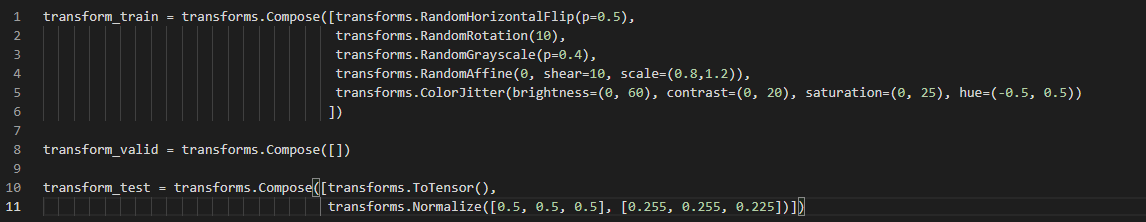


* Please pay attention to data augmentations technique we're using.
* Notice how we don't use  `torchvision.transforms.ToTensor()` nor `torchvision.transforms.Normalize(mean, std, inplace=False)`
* The reason behind this, is that i've already applied normalization and standardization to train dataset `X_train` as well as `X_valid`
*  BUT, X_train is a tensor with shape `N_samples x H x W x C`, and you CAN"T apply
1. torchvision.transforms.RandomHorizontalFlip(p=0.5) on a tensor with shape `N_samples x H x W x C`, you can read the pytorch documentation for further investigations.
2. Solution to this problem: Rearrange the dimentions.

* ` From N x H x W x C TO N x C x H x W`

3. We got rid of two essential transformations: `torchvision.transforms.ToTensor()` and `torchvision.transforms.Normalize(mean, std)`, but we're still going to apply these two transformations to `TEST_DATASET`


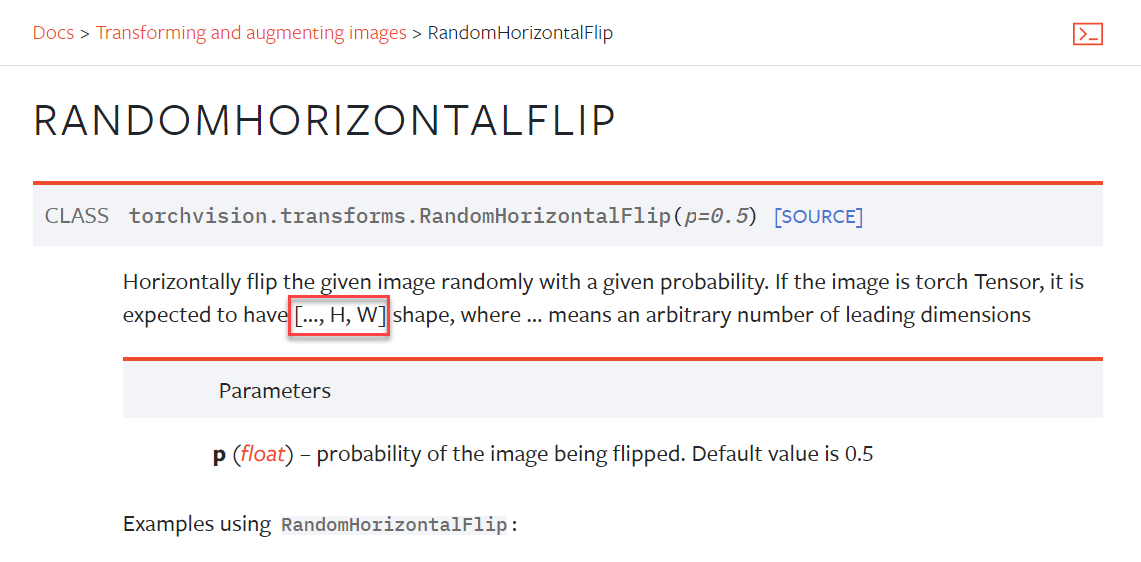

In [ ]:
X_train = X_train.permute(0, 3, 1, 2)
X_valid = X_valid.permute(0, 3, 1, 2)
# X_test = X_test.permute(0, 3, 1, 2)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
# print(X_test.shape)

torch.Size([1119, 3, 100, 100])
torch.Size([480, 3, 100, 100])


## **Custom Dataset Class**
why do we need a custom Dataset class:
1. A custom Dataset Class help us apply transformation to our train dataset, validation dataset, and test dataset. 
*  At the beginning we had only a `training dataset` inside `Data folder`
*  **Here we have a problem?** it's easy to apply transform to an entire dataset, Simply you just pass the directory of your dataset, and pass the data augmentation transforms you want to apply, and later on you can use Dataloader and feed the train data loader to Neural network.

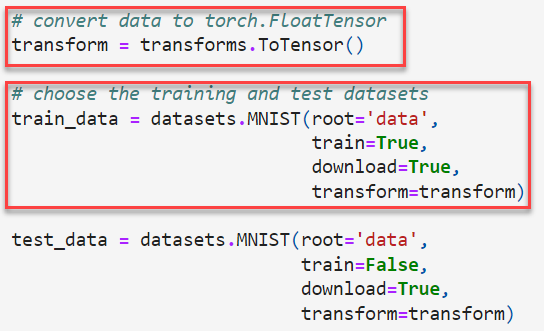

*  But for our specific problem we can't apply data augmentation on the entire training dataset, remember our training data was divided into folders:
* `A_0` : Hand sign of zero `0`
* `A_1` : Hand sign of zero `1`
* `A_2` : Hand sign of zero `2`
* `A_3` : Hand sign of zero `3`
* `A_4` : Hand sign of zero `4`
* `A_5` : Hand sign of zero `5`
* `A_6` : Hand sign of zero `6`
* `A_7` : Hand sign of zero `7`
* `A_8` : Hand sign of zero `8`
* `A_9` : Hand sign of zero `9`

1. we'd to extracted the images inside each folder, then we'd to apply normalization and standardization.
2. we'd to concatenate the data into `X_data` and `y_labels`.
3. Cross_validation:  70% of the whole dataset is used as a training set and the remaining 30% is used as the validation set.
4. we'd to re-arrange our dimentions so we can apply data augmentation techniques.



In [ ]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
class CustomTensorDataset(Dataset):
    """ TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


In [ ]:
# Functions for training
def get_dataloader(train_ds, valid_ds, test_ds,bs):
    '''
        Get dataloaders of the training and validation set.
        Parameter:
            train_ds: Dataset
                Training set
            valid_ds: Dataset
                Validation set
            bs: Int
                Batch size

        Return:
            (train_dl, valid_dl): Tuple of DataLoader
                Dataloaders of training and validation set.
    '''
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs, shuffle=False),
        DataLoader(test_ds, batch_size=bs, shuffle=True)
    )


In [ ]:
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomRotation(30),
                                      transforms.RandomGrayscale(p=0.5),
                                      transforms.RandomInvert(p=0.5)
                                      # transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      # transforms.ColorJitter(brightness=(0, 60), contrast=(0, 20), saturation=(0, 25), hue=(-0.5, 0.5))
                                     ])
 
transform_valid = transforms.Compose([])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
train_ds = CustomTensorDataset(tensors=(X_train, y_train), transform=transform_train)
valid_ds = CustomTensorDataset(tensors = (X_valid, y_valid), transform=transform_valid)
test_ds = datasets.ImageFolder('/content/drive/MyDrive/Data/dataset' , transform=transform_test)

In [ ]:
# test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Data/dataset' , transform=transform_test)

image_datasets = {}
image_datasets['train'] = train_ds
image_datasets['val'] = valid_ds
image_datasets['test'] = test_ds


dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
               'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False),
               'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=True)
              } 


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
class_names = classes


In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  
  image = image.transpose(1, 2, 0)
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  image = image.clip(0, 1)
  return image

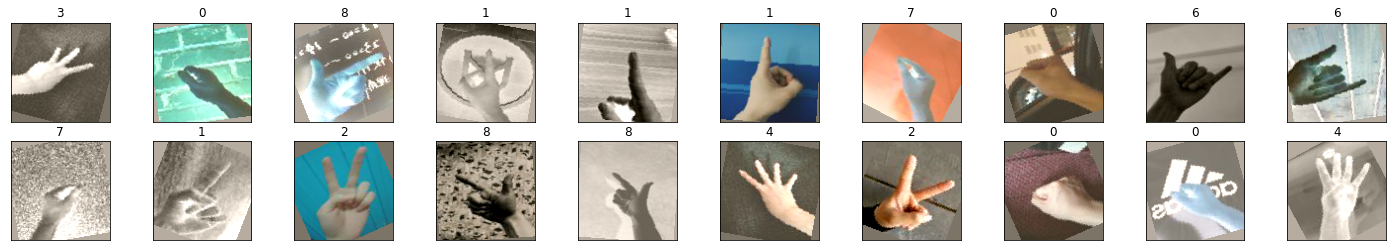

In [ ]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

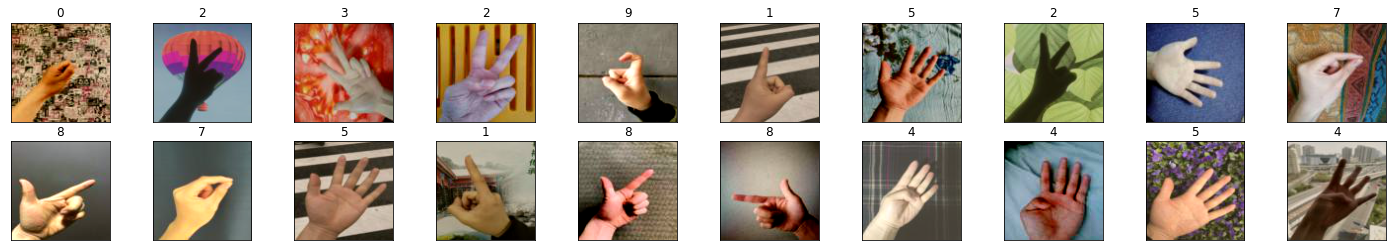

In [ ]:
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

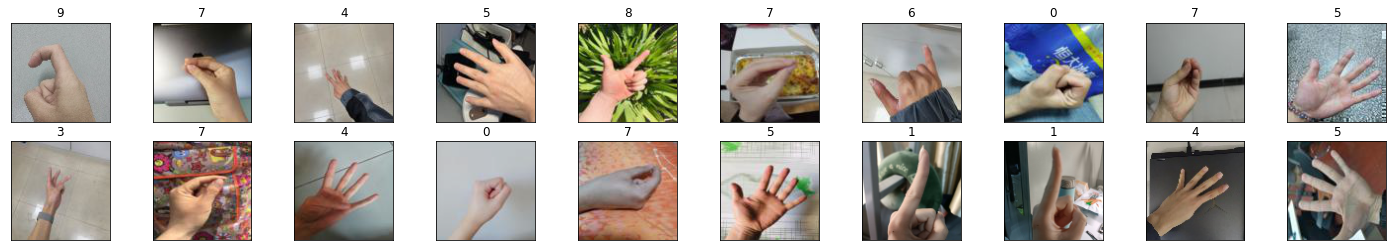

In [ ]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
import pandas as pd

def loss_batch(model, loss_func, xb, yb, opt=None):
    
    '''
        Parameter:
            model: Module
                Your neural network model
            loss_func: Loss
                Loss function, e.g. CrossEntropyLoss()
            xb: Tensor
                One batch of input x
            yb: Tensor
                One batch of true label y
            opt: Optimizer
                Optimizer, e.g. SGD()
        
        Return:
            loss.item(): Python number
                Loss of the current batch
            len(xb): Int
                Number of examples of the current batch
            pred: ndarray
                Predictions (class with highest probability) of the minibatch 
                input xb
    '''
    out = model(xb)
    # print('out.shape', out.shape)
    pred = torch.argmax(out, dim=1).cpu()
    # print("pred.shape", pred.shape)
    loss = loss_func(out, yb)
    # print("loss", loss)
    

    if opt is not None:
        
        loss.backward()
        opt.step()
        opt.zero_grad()

    
    return loss.item(), len(xb), pred

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, train_metric=False, schedular=None):
    '''
        Train the NN model and return the model at the final step.
        Lists of the training and validation losses at each epochs are also 
        returned.

        Parameter:
            epochs: int
                Number of epochs to run.
            model: Module
                Your neural network model
            loss_func: Loss
                Loss function, e.g. CrossEntropyLoss()
            opt: Optimizer
                Optimizer, e.g. SGD()
            train_dl: DataLoader
                Dataloader of the training set.
            valid_dl: DataLoader
                Dataloader of the validation set.
            train_metric: Bool
                Default is False. If False, the train loss and accuracy will be
                set to 0.
                If True, the loss and accuracy of the train set will also be 
                computed.

        Return:
            model: Module
                Trained model.
            metrics: DataFrame
                DataFrame which contains the train and validation loss at each
                epoch.
    '''
    print(
        'EPOCH', '\t', 
        'Train Loss', '\t',
        'Val Loss', '\t', 
        'Train Acc', '\t',
        'Val Acc', '\t')
    # Initialize dic to store metrics for each epoch.
    metrics_dic = {}
    metrics_dic['train_loss'] = []
    metrics_dic['train_accuracy'] = []
    metrics_dic['val_loss'] = []
    metrics_dic['val_accuracy'] = []

    # early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        num_examples = 0
        
        
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            #print("xb, yb shapes", xb.shape, yb.shape)
            #print("model(xb).shape", model(xb).shape)
            # yb = yb.view(1, -1)
            loss, batch_size, pred = loss_batch(model, loss_func, xb, yb, opt)
            if train_metric == False:
                train_loss += loss
                num_examples += batch_size
            
        # Validate
        model.eval()
        with torch.no_grad():
            val_loss, val_accuracy, _ = validate(model, valid_dl, loss_func)
            
            if train_metric:
                train_loss, train_accuracy, _ = validate(model, train_dl, loss_func)
                ##########################
                schedular.step()
                ##########################
            else:
                train_loss = train_loss / num_examples

        metrics_dic['val_loss'].append(val_loss)
        metrics_dic['val_accuracy'].append(val_accuracy)
        metrics_dic['train_loss'].append(train_loss)
        metrics_dic['train_accuracy'].append(train_accuracy)
        
        print(
            f'{epoch} \t', 
            f'{train_loss:.05f}', '\t',
            f'{val_loss:.05f}', '\t', 
            f'{train_accuracy:.05f}', '\t'
            f'{val_accuracy:.05f}', '\t')
        
    metrics = pd.DataFrame.from_dict(metrics_dic)

    return model, metrics
    
def validate(model, dl, loss_func):
    total_loss = 0.0
    total_size = 0
    predictions = []
    y_true = []
    for xb, yb in dl: 
        xb, yb = xb.to(device), yb.to(device)

        loss, batch_size, pred = loss_batch(model, loss_func, xb, yb)
        total_loss += loss*batch_size
        total_size += batch_size
        predictions.append(pred)
        y_true.append(yb.cpu().numpy())
    mean_loss = total_loss / total_size
    
    predictions = np.concatenate(predictions, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    accuracy = np.mean((predictions == y_true))

    return mean_loss, accuracy, (y_true, predictions)

In [ ]:
from torch.optim import lr_scheduler

model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_resnet18.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_resnet18 = model_resnet18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_resnet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1, verbose=True)

# num_epochs 
epochs = 35

Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
# ---------------- RUN IF YOU WANT TO TRAIN THE MODEL ONLY ------------------- #
import time
tic = time.time()
## Train
model_resnet18_8, metrics = fit(epochs, model_resnet18, criterion, optimizer_ft, dataloaders['train'], dataloaders['val'], train_metric=True, schedular= exp_lr_scheduler)
toc = time.time()
print(toc-tic)

EPOCH 	 Train Loss 	 Val Loss 	 Train Acc 	 Val Acc 	
Adjusting learning rate of group 0 to 1.0000e-02.
0 	 2.55510 	 2.89215 	 0.32261 	0.28750 	
Adjusting learning rate of group 0 to 1.0000e-02.
1 	 1.99923 	 2.31454 	 0.42449 	0.43542 	
Adjusting learning rate of group 0 to 1.0000e-02.
2 	 1.36254 	 1.27123 	 0.51921 	0.52917 	
Adjusting learning rate of group 0 to 1.0000e-02.
3 	 0.93938 	 0.99380 	 0.62645 	0.61250 	
Adjusting learning rate of group 0 to 1.0000e-02.
4 	 1.14249 	 1.22240 	 0.59428 	0.59167 	
Adjusting learning rate of group 0 to 1.0000e-02.
5 	 1.30028 	 1.77970 	 0.57462 	0.50417 	
Adjusting learning rate of group 0 to 1.0000e-02.
6 	 1.07646 	 1.16367 	 0.60322 	0.58125 	
Adjusting learning rate of group 0 to 1.0000e-02.
7 	 0.88859 	 0.89409 	 0.68365 	0.69792 	
Adjusting learning rate of group 0 to 1.0000e-02.
8 	 0.59534 	 0.54865 	 0.78731 	0.80833 	
Adjusting learning rate of group 0 to 1.0000e-03.
9 	 0.65556 	 0.85078 	 0.77212 	0.72292 	
Adjusting learni

In [ ]:
working_dir = Path('../content/drive/MyDrive')
DATA_PATH = Path("../content/drive/MyDrive/Data")
save_model_path = working_dir / 'Transfer_learning_resnet'

for path in [DATA_PATH, save_model_path]:
    if not path.exists():
        path.mkdir(parents=True)

In [ ]:
# CHange this value to your last accuracy found after running "train"
                                                              ###################                                                    
torch.save(model_resnet18_7.state_dict(), save_model_path / f'model_resnet18_7_val_no_color_invert{str(0.88125)}_model.pth' )

In [ ]:
# ---------- AFTER TRAINING YOU NEED TO SAVE UP YOUR MODEL METRICS FOR LATER VISULIZATIONS ------------------- #
metrics.to_csv(r'/content/drive/MyDrive/DataFrames/model_resnet18_7_val_no_invert_0.88125.csv', index=False)

In [ ]:
# ----------- I HAVE ALREADY SAVED MY METRICS dataframe INTO A CSV file IN MY DRIVE --------- #
# ----------- here is a link: https://drive.google.com/file/d/18dTgPtfA6Fp0U3znaCtz0EzAvJX0O6i-/view?usp=sharing
metrics_resnet18_7 = pd.read_csv('/content/drive/MyDrive/DataFrames/model_resnet18_7_val_no_invert_0.88125.csv').to_dict()
print(metrics_resnet18_7)

{'train_loss': {0: 8.048445962815544, 1: 1.9252526885809056, 2: 1.5130600898365978, 3: 1.175457774687282, 4: 0.847005805232037, 5: 1.0262837608122637, 6: 0.9940398818046734, 7: 1.0137701781867765, 8: 0.945059118417888, 9: 1.0106000142826153, 10: 0.4787838702440475, 11: 0.3815318654699982, 12: 0.3266437639872659, 13: 0.3067599643651026, 14: 0.2753114184169922, 15: 0.2358430669816931, 16: 0.2444710210831278, 17: 0.2078835636483866, 18: 0.1858505961669141, 19: 0.2108312595146271, 20: 0.1498817330737323, 21: 0.1501220945831491, 22: 0.145913540058577, 23: 0.1460832287761332, 24: 0.1393138427517049, 25: 0.1414057555424517, 26: 0.1371729555169421, 27: 0.1234794192555442, 28: 0.1326935877615687, 29: 0.1186990917954091}, 'train_accuracy': {0: 0.1465594280607685, 1: 0.3833780160857908, 2: 0.4244861483467381, 3: 0.5603217158176944, 4: 0.7247542448614834, 5: 0.6273458445040214, 6: 0.6604110813226095, 7: 0.6371760500446828, 8: 0.6487935656836461, 9: 0.6371760500446828, 10: 0.8588025022341377, 11: 0

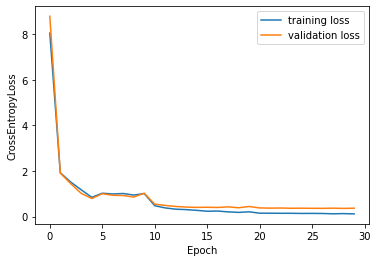

In [ ]:
plt.plot(np.array(list(metrics_resnet18_7 ['train_loss'].values())).astype(float), label='training loss')
plt.plot(np.array(list(metrics_resnet18_7 ['val_loss'].values())).astype(float), label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropyLoss')
plt.legend()

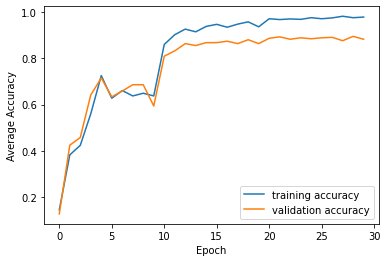

In [ ]:
plt.plot(np.array(list(metrics_resnet18_7 ['train_accuracy'].values())).astype(float), label='training accuracy')
plt.plot(np.array(list(metrics_resnet18_7 ['val_accuracy'].values())).astype(float), label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.legend()

In [ ]:
load_path = '/content/drive/MyDrive/Transfer_learning_resnet/model_resnet18_7_val_no_color_invert0.88125_model.pth'
model_checkpoint = torch.load(load_path)
# if the model is not defined it shoudlbe define again here before 
# the method model.load_state_dict() is called

In [ ]:
model_resnet18_7 = models.resnet18(pretrained=True)
model_resnet18_7 = model_resnet18_7.to(device)
num_ftrs = model_resnet18_7.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_resnet18_7.fc = nn.Linear(num_ftrs, 10)

In [ ]:
model_resnet18_7.load_state_dict(model_checkpoint)

<All keys matched successfully>

In [ ]:
tic = time.time()
model_resnet18_7 = model_resnet18_7.to(device)
mean_loss, accuracy, (y_true, predictions) = validate(model_resnet18_7, dataloaders['test'], criterion)
print(mean_loss, accuracy)
toc = time.time()
print("time passed", toc-tic)

0.8433650409589049 0.7300546448087432
time passed 13.938471555709839


In [ ]:
test_ds_M = datasets.ImageFolder('/content/drive/MyDrive/Data/test_images_resized' , transform=transform_test)

In [ ]:
dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
               'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False),
               'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=True),
               'test_M': DataLoader(test_ds_M, batch_size=32, shuffle=True)} 

In [ ]:
tic = time.time()
model_resnet18_7 = model_resnet18_7.to(device)
mean_loss, accuracy, (y_true, predictions) = validate(model_resnet18_7, dataloaders['test_M'], criterion)
print(mean_loss, accuracy)
toc = time.time()
print("time passed", toc-tic)

2.086439514160156 0.34
time passed 0.33464837074279785


In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  
  image = image.transpose(1, 2, 0)
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  image = image.clip(0, 1)
  return image

## **Visualize Sample Test Results**

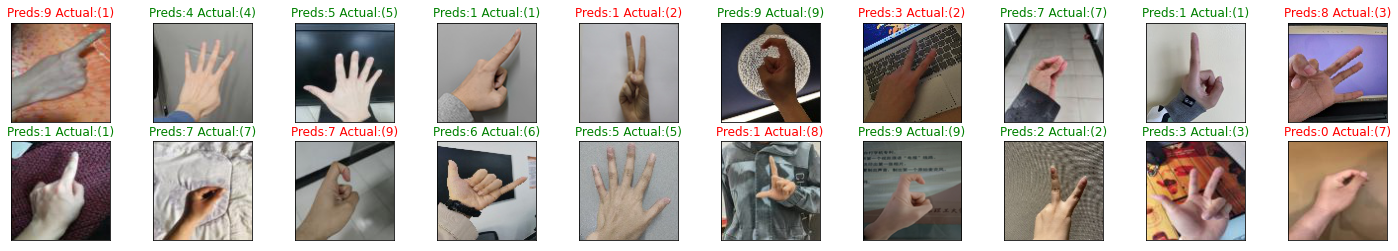

In [ ]:
# obtain one batch of test images
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

# get sample outputs
model = model_resnet18_7.cpu()
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(im_convert(images[idx]), cmap='gray')
    ax.set_title("Preds:{} Actual:({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))